In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

# Zad1 - OneMax, DeceptiveOneMax, K-DeceptiveOneMax

In [1]:
def eval_population_onemax(ppl):
    return ppl.sum(axis=1)

def eval_population_deceptive_onemax(ppl):
    s = ppl.sum(axis=1)
    s[s == 0 ] = ppl.shape[1] + 1
    return s

def eval_population_k_deceptive_onemax(ppl):
    k=5
    ppl = ppl.reshape(ppl.shape[0],k,-1)
    s = ppl.sum(axis=2)
    s[s == 0 ] = ppl.shape[2] + 1
    s = s.sum(axis=1)
    return s 

def random_population(N, ppbs):
    return (np.random.rand(N, ppbs.shape[0]) < ppbs).astype(float)
    

def PBIL(N, d, F, theta1, theta2, theta3, iters=1000, log_every=0):
    maxes = []
    ppbs_history = np.empty((iters, d))
    ppbs = np.array([0.5] * d)
    population = random_population(N, ppbs)
    eval_vector = F(population)
    
    for i in range(iters):
        best_x = population[np.argmax(eval_vector)]
        ppbs = ppbs * (1.0-theta1) + best_x*theta1
        
        #mutation
        ppbs = ppbs - ((np.random.rand(d) < theta2)).astype(float)  \
            * (ppbs*theta3 - (np.random.rand(d) < 0.5).astype(float)*theta3)
    
        #new population
        population = random_population(N, ppbs)
        eval_vector = F(population)
        
        maxes.append(eval_vector.max())
        ppbs_history[i] = ppbs
        if log_every != 0 and i % log_every == 0:
            print("Iteration: " + str(i) + ". Current max: " + str(max(maxes)))
    
    return { "population":population,
            "max_history":np.array(maxes),
           "probabilites":ppbs_history}

def CGA(d, F, theta, iters=1000, log_every=0):
    maxes = []
    ppbs_history = np.empty((iters, d))
    ppbs = np.array([0.5] * d)
    population = random_population(2, ppbs)
    eval_vector = F(population)
    
    for i in range(iters):
        best_x = population[np.argmax(eval_vector)]
        worst_x = population[np.argmin(eval_vector)]
        
        for k in range(d):
            if best_x[k] == 1 and worst_x[k] == 0:
                ppbs[k] += theta
            elif best_x[k] == 0 and worst_x[k] == 1:
                ppbs[k] -= theta
        #new population
        population = random_population(2, ppbs)
        eval_vector = F(population)
        
        maxes.append(eval_vector.max())
        ppbs_history[i] = ppbs
        if log_every != 0 and i % log_every == 0:
            print("Iteration: " + str(i) + ". Current max: " + str(max(maxes)))
    
    return { "population":population,
            "max_history":np.array(maxes),
           "probabilites":ppbs_history}

def UMDA(N, M, d, F, iters=1000, log_every=0):
    maxes = []
    ppbs_history = np.empty((iters, d))
    ppbs = np.array([0.5] * d)
    population = random_population(N, ppbs)
    eval_vector = F(population)
    
    for i in range(iters):
        # Selection
        I = np.argsort(eval_vector)
        population = population[I[:M:-1]]
        
        # Model estimation
        ppbs = population.mean(0)
        #new population
        
        population = random_population(N, ppbs)
        eval_vector = F(population)
        
        maxes.append(eval_vector.max())
        ppbs_history[i] = ppbs
        if log_every != 0 and i % log_every == 0:
            print("Iteration: " + str(i) + ". Current max: " + str(max(maxes)))
    
    return { "population":population,
            "max_history":np.array(maxes),
           "probabilites":ppbs_history}

def MIMIC(N, M, d, F, iters=1000, log_every=0):
    maxes = []
    ppbs_history = np.empty((iters, d))
    ppbs = np.array([0.5] * d)
    population = random_population(N, ppbs)
    eval_vector = F(population)
    
    for i in range(iters):
        # Update parameters
        depend_permut = dependency_permutation(population)
        
        # New population
        new_population = generate_samples(population, depend_permut, M)
        
        new_eval_vector = F(new_population)
        
        population = np.vstack([population, new_population])
        eval_vector = np.hstack([eval_vector, new_eval_vector])
        
        population = population[np.where(eval_vector >= np.median(eval_vector))]
        eval_vector = eval_vector[eval_vector >= np.median(eval_vector)]
        maxes.append(eval_vector.max())
        if log_every != 0 and i % log_every == 0:
            print("Iteration: " + str(i) + ". Current max: " + str(max(maxes)))
    
    return { "population":population,
            "max_history":np.array(maxes)}

def dependency_permutation(population):
    N = population.shape[0]
    d = population.shape[1]
    
    ppbs = population.mean(axis=0)
    ppbs[ppbs==0.0] += 1e-8
    if(np.any(ppbs<=0.0) or np.any(ppbs>1.0)): 
        print("BLAD")
        print(ppbs)
        print(population)
        
    log_ppbs = np.log(ppbs).reshape(-1,1)
    ppbs = ppbs[None]
    entropies = -np.dot(log_ppbs, ppbs) - np.dot(np.log(1.0-ppbs + 1e-10).reshape(-1,1), 1.0-ppbs)
    
    last_idx = np.argmin(np.diag(entropies))
    permutation = np.empty((d)).astype(int)
    permutation[0] = last_idx
    
    permuted = np.array([False]*d)
    permuted[last_idx] = True
    
    for i in range(1, d):
        best_idx = -1
        best_entropy = 99999999
        for k in range(d):
            if entropies[last_idx, k] < best_entropy and permuted[k] == False:
                best_entropy = entropies[last_idx, k]
                best_idx = k
        
        last_idx = best_idx
        permuted[last_idx] = True
        permutation[i] = last_idx
        
    return permutation
        
def generate_samples(ppl, permut, new_sample_num):
    d = ppl.shape[1]
    cond_ppbs = np.empty((d,2))

    cond_ppbs[permut[0],:] = ppl[:, permut[0]].mean()
    
    for i in range(1,d):
        cond_ppbs[permut[i], 0] = ppl[ppl[:,permut[i-1]]==0][:, permut[i]].mean()
        cond_ppbs[permut[i], 1] = ppl[ppl[:,permut[i-1]]==1][:, permut[i]].mean()
    
    
    new_ppl = np.empty((new_sample_num, d))
    new_ppl[:,permut[0]] = (np.random.rand(new_sample_num) < cond_ppbs[permut[0], 0]).astype(float)

    for i in range(1, d):
        for k in range(new_sample_num):
            new_ppl[k, permut[i]] = (np.random.rand() < cond_ppbs[permut[i], int(new_ppl[k, permut[i-1]])]).astype(float)
        
    return new_ppl
    


## PBIL

OneMax problem:


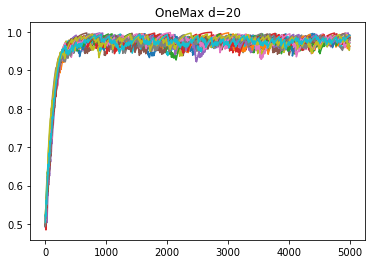

max:20.0


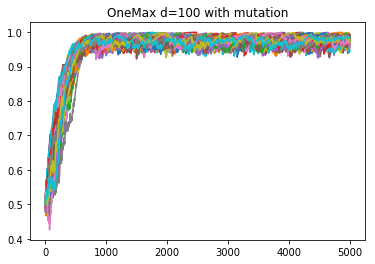

max:100.0


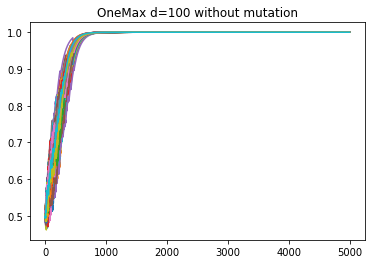

max:100.0
Deceptive OneMax problem:


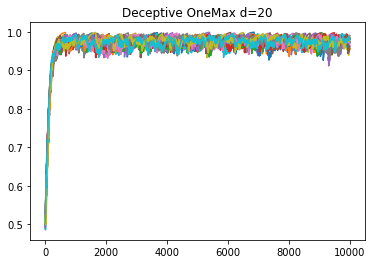

max:20.0


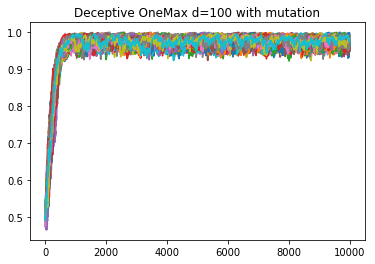

max:100.0


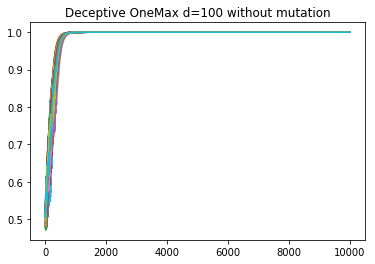

max:100.0
5-Deceptive OneMax problem:


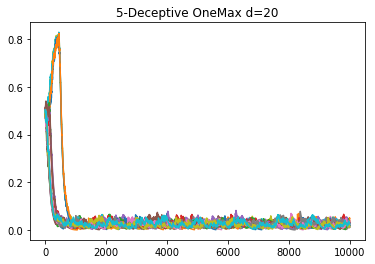

max:25.0


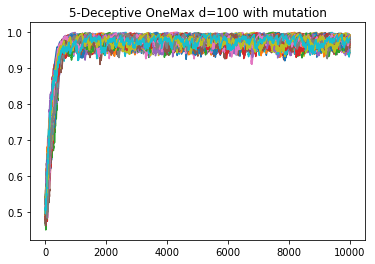

max:100.0


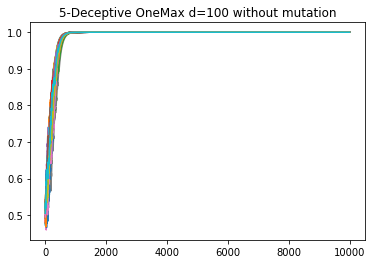

max:100.0


In [46]:
#################################
# ONE MAX
#################################
print("OneMax problem:")
result = PBIL(125, 20, eval_population_onemax, 0.01, 0.05, 0.01, iters=5000)
ff = plt.figure()
plt.plot(result["probabilites"])
plt.title('OneMax d=20')
plt.show()
print('max:' + str(max(result["max_history"])))

result = PBIL(125, 100, eval_population_onemax, 0.01, 0.05, 0.01, iters=5000)
plt.figure()
plt.plot(result["probabilites"])
plt.title('OneMax d=100 with mutation')
plt.show()
print('max:' + str(max(result["max_history"])))

result = PBIL(125, 100, eval_population_onemax, 0.01, 0.00, 0.01, iters=5000)
plt.figure()
plt.plot(result["probabilites"])
plt.title('OneMax d=100 without mutation')
plt.show()
print('max:' + str(max(result["max_history"])))

#################################
# DECEPTIVE ONE MAX
#################################
print("Deceptive OneMax problem:")
result = PBIL(200, 20, eval_population_deceptive_onemax, 0.01, 0.05, 0.01, iters=10000)
plt.figure()
plt.plot(result["probabilites"])
plt.title('Deceptive OneMax d=20')
plt.show()
print('max:' + str(max(result["max_history"])))
    
result = PBIL(200, 100, eval_population_deceptive_onemax, 0.01, 0.05, 0.01, iters=10000)
plt.figure()
plt.plot(result["probabilites"])
plt.title('Deceptive OneMax d=100 with mutation')
plt.show()
print('max:' + str(max(result["max_history"])))

result = PBIL(200, 100, eval_population_deceptive_onemax, 0.01, 0.00, 0.01, iters=10000)
plt.figure()
plt.plot(result["probabilites"])
plt.title('Deceptive OneMax d=100 without mutation')
plt.show()
print('max:' + str(max(result["max_history"])))
    
    
#################################
# K-DECEPTIVE ONE MAX
#################################
print("5-Deceptive OneMax problem:")
result = PBIL(200, 20, eval_population_k_deceptive_onemax, 0.01, 0.05, 0.01, iters=10000)
ff = plt.figure()
plt.plot(result["probabilites"])
plt.title('5-Deceptive OneMax d=20')
plt.show()
print('max:' + str(max(result["max_history"])))
    
result = PBIL(200, 100, eval_population_k_deceptive_onemax, 0.01, 0.05, 0.01, iters=10000)
plt.figure()
#plt.plot(result["max_history"])
plt.plot(result["probabilites"])
plt.title('5-Deceptive OneMax d=100 with mutation')
plt.show()
print('max:' + str(max(result["max_history"])))

result = PBIL(200, 100, eval_population_k_deceptive_onemax, 0.01, 0.00, 0.01, iters=10000)
plt.figure()
#plt.plot(result["max_history"])
plt.plot(result["probabilites"])
plt.title('5-Deceptive OneMax d=100 without mutation')
plt.show()
print('max:' + str(max(result["max_history"])))

## UMDA

OneMax problem:


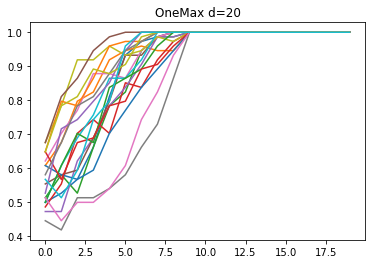

max:20.0


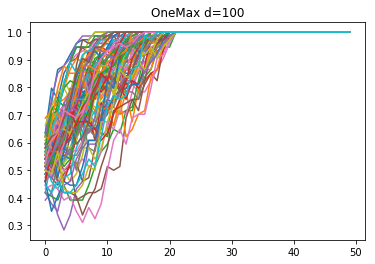

max:100.0
Deceptive OneMax problem:


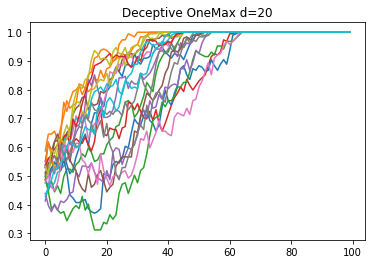

max:20.0


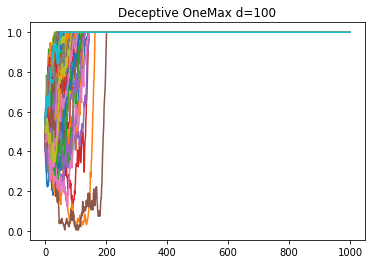

max:100.0
5-Deceptive OneMax problem:


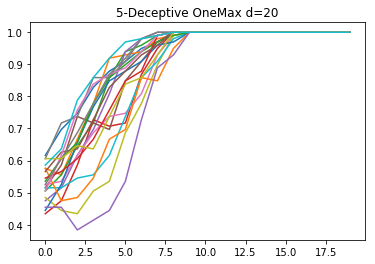

max:20.0


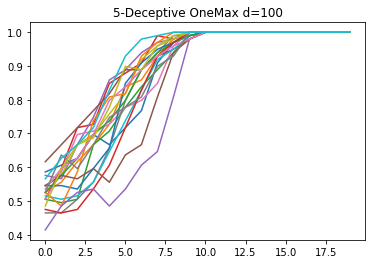

max:21.0


In [67]:
# UMDA(N, M, d, F, iters=1000, log_every=0)
#################################
# ONE MAX
#################################
print("OneMax problem:")
result = UMDA(125, 50, 20, eval_population_onemax, iters=20)
ff = plt.figure()
plt.plot(result["probabilites"])
plt.title('OneMax d=20')
plt.show()
print('max:' + str(max(result["max_history"])))

result = UMDA(125, 50, 100, eval_population_onemax, iters=50)
plt.figure()
plt.plot(result["probabilites"])
plt.title('OneMax d=100')
plt.show()
print('max:' + str(max(result["max_history"])))

#################################
# DECEPTIVE ONE MAX
#################################
print("Deceptive OneMax problem:")
result = UMDA(200, 10, 20, eval_population_deceptive_onemax, iters=100)
plt.figure()
plt.plot(result["probabilites"])
plt.title('Deceptive OneMax d=20')
plt.show()
print('max:' + str(max(result["max_history"])))

result = UMDA(200, 10, 100, eval_population_deceptive_onemax, iters=1000)
plt.figure()
plt.plot(result["probabilites"])
plt.title('Deceptive OneMax d=100')
plt.show()
print('max:' + str(max(result["max_history"])))
    
#################################
# K-DECEPTIVE ONE MAX
#################################
print("5-Deceptive OneMax problem:")
result = UMDA(200, 100, 20, eval_population_k_deceptive_onemax, iters=20)
ff = plt.figure()
plt.plot(result["probabilites"])
plt.title('5-Deceptive OneMax d=20')
plt.show()
print('max:' + str(max(result["max_history"])))
    
result = UMDA(200, 100, 100, eval_population_k_deceptive_onemax, iters=20)
plt.figure()
#plt.plot(result["max_history"])
plt.plot(result["probabilites"])
plt.title('5-Deceptive OneMax d=100')
plt.show()
print('max:' + str(max(result["max_history"])))


## CGA 

OneMax problem:


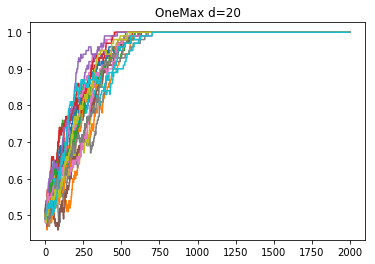

max:20.0


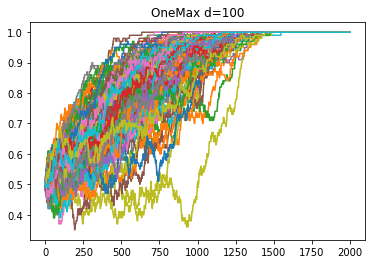

max:100.0
Deceptive OneMax problem:


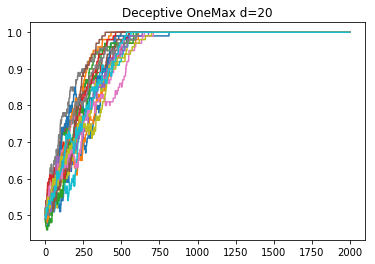

max:20.0


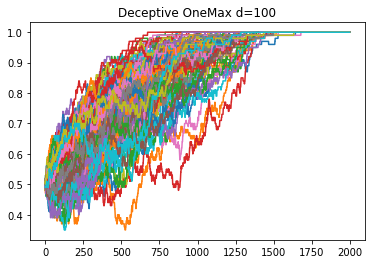

max:100.0
5-Deceptive OneMax problem:


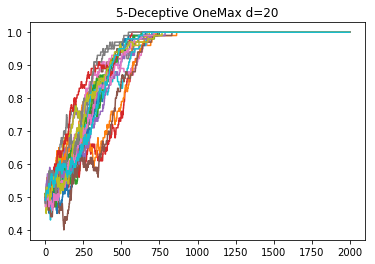

max:21.0


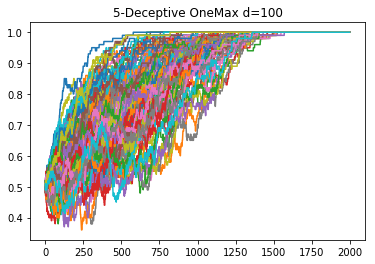

max:100.0


In [68]:
#################################
# ONE MAX
#################################
print("OneMax problem:")
result = CGA(20, eval_population_onemax, 0.01, iters=2000)
ff = plt.figure()
plt.plot(result["probabilites"])
plt.title('OneMax d=20')
plt.show()
print('max:' + str(max(result["max_history"])))

result = CGA(100, eval_population_onemax, 0.01, iters=2000)
plt.figure()
plt.plot(result["probabilites"])
plt.title('OneMax d=100')
plt.show()
print('max:' + str(max(result["max_history"])))

#################################
# DECEPTIVE ONE MAX
#################################
print("Deceptive OneMax problem:")
result = CGA(20, eval_population_deceptive_onemax, 0.01, iters=2000)
plt.figure()
plt.plot(result["probabilites"])
plt.title('Deceptive OneMax d=20')
plt.show()
print('max:' + str(max(result["max_history"])))

result = CGA(100, eval_population_deceptive_onemax, 0.01, iters=2000)
plt.figure()
plt.plot(result["probabilites"])
plt.title('Deceptive OneMax d=100')
plt.show()
print('max:' + str(max(result["max_history"])))
    
#################################
# K-DECEPTIVE ONE MAX
#################################
print("5-Deceptive OneMax problem:")
result = CGA(20, eval_population_k_deceptive_onemax, 0.01, iters=2000)
ff = plt.figure()
plt.plot(result["probabilites"])
plt.title('5-Deceptive OneMax d=20')
plt.show()
print('max:' + str(max(result["max_history"])))
    
result = CGA(100, eval_population_k_deceptive_onemax, 0.01, iters=2000)
plt.figure()
#plt.plot(result["max_history"])
plt.plot(result["probabilites"])
plt.title('5-Deceptive OneMax d=100')
plt.show()
print('max:' + str(max(result["max_history"])))


## MIMIC

OneMax problem:


/home/satyr/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:148: RuntimeWarning: Mean of empty slice.


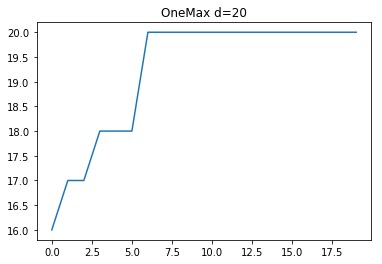

max:20.0


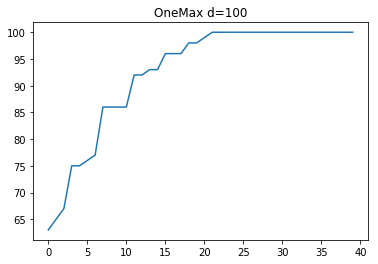

max:100.0
Deceptive OneMax problem:


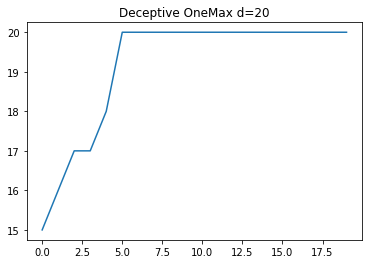

max:20.0


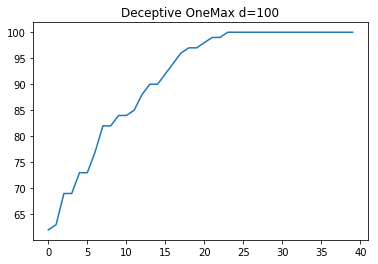

max:100.0
5-Deceptive OneMax problem:


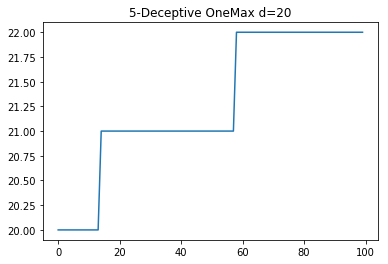

max:22.0


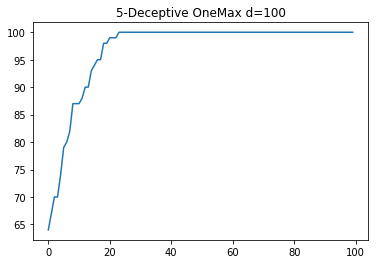

max:100.0


In [237]:
#def MIMIC(N, M, d, F, iters=1000, log_every=0):

#################################
# ONE MAX
#################################
print("OneMax problem:")
result = MIMIC(100, 50, 20, eval_population_onemax, iters=20)
ff = plt.figure()
plt.plot(result["max_history"])
plt.title('OneMax d=20')
plt.show()
print('max:' + str(max(result["max_history"])))

result = MIMIC(100, 50, 100, eval_population_onemax, iters=40)
plt.figure()
plt.plot(result["max_history"])
plt.title('OneMax d=100')
plt.show()
print('max:' + str(max(result["max_history"])))

#################################
# DECEPTIVE ONE MAX
#################################
print("Deceptive OneMax problem:")
result = MIMIC(100, 50, 20, eval_population_deceptive_onemax, iters=20)
plt.figure()
plt.plot(result["max_history"])
plt.title('Deceptive OneMax d=20')
plt.show()
print('max:' + str(max(result["max_history"])))

result = MIMIC(100, 50, 100, eval_population_deceptive_onemax, iters=40)
plt.figure()
plt.plot(result["max_history"])
plt.title('Deceptive OneMax d=100')
plt.show()
print('max:' + str(max(result["max_history"])))
    
#################################
# K-DECEPTIVE ONE MAX
#################################
print("5-Deceptive OneMax problem:")
result = MIMIC(400, 200, 20, eval_population_k_deceptive_onemax, iters=100)
ff = plt.figure()
plt.plot(result["max_history"])
plt.title('5-Deceptive OneMax d=20')
plt.show()
print('max:' + str(max(result["max_history"])))
    
result = MIMIC(400, 200, 100, eval_population_k_deceptive_onemax, iters=100)
plt.figure()
#plt.plot(result["max_history"])
plt.plot(result["max_history"])
plt.title('5-Deceptive OneMax d=100')
plt.show()
print('max:' + str(max(result["max_history"])))


# Zad 1

Klasyfikacja wielospektralna obrazów satelitarnych.
Wymaga folderu "lista01"(http://www.ii.uni.wroc.pl/~lipinski/AE2018/lista01.zip) w katalogu z arkuszem.

## PBIL

Iteration: 0. Current max: 8578.0
Iteration: 20. Current max: 8864.0
Iteration: 40. Current max: 9032.0
Iteration: 60. Current max: 9130.0
Iteration: 80. Current max: 9130.0
Iteration: 100. Current max: 9151.0
Iteration: 120. Current max: 9162.0
Iteration: 140. Current max: 9162.0
Iteration: 160. Current max: 9166.0
Iteration: 180. Current max: 9175.0
Iteration: 200. Current max: 9175.0
Iteration: 220. Current max: 9179.0
Iteration: 240. Current max: 9186.0
Iteration: 260. Current max: 9192.0
Iteration: 280. Current max: 9192.0
Iteration: 300. Current max: 9192.0
Iteration: 320. Current max: 9192.0
Iteration: 340. Current max: 9193.0
Iteration: 360. Current max: 9193.0
Iteration: 380. Current max: 9197.0
Iteration: 400. Current max: 9197.0
Iteration: 420. Current max: 9198.0
Iteration: 440. Current max: 9198.0
Iteration: 460. Current max: 9199.0
Iteration: 480. Current max: 9199.0
Iteration: 500. Current max: 9201.0
Iteration: 520. Current max: 9201.0
Iteration: 540. Current max: 9201.

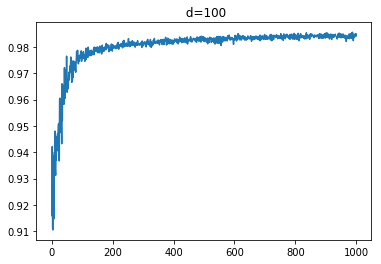

max:0.985561497326
time: 3082.592123031616


In [293]:
def eval_classification_loss(ppl):
    # ppl is N x 266
    # returns eval_vector 1xN
    eval_vector = np.empty(ppl.shape[0])
    for i in range(ppl.shape[0]):
        classes = []
        C = (classifs.T * ppl[i]).astype(int)
        for px in range(9350):
            classes.append(np.argmax(np.bincount(C[px])[1:]) + 1)
        eval_vector[i] = (np.array(classes) == experts).sum()
    return eval_vector
    
experts = np.empty((1, 9350))
classifs = np.empty((266, 9350))

for i,l in enumerate(open("lista01/ImageExpertReduced.txt", 'r')):
    experts[:] = [float(x) for x in l.split()]
    
for i,l in enumerate(open("lista01/ClassificationRules.txt", 'r')):
    classifs[i] = [float(x) for x in l.split()]
    

t0 = time.time()
p, m = PBIL(50, 266, eval_classification_loss, 0.025, 0.05, 0.01, iters=1000, log_every=20)
plt.figure()
plt.plot(m/9350.0)
plt.title(' d=100')
plt.show()
print('max:' + str(max(m)/9350.0))
print('time: ' + str(time.time() - t0))

## CGA

Iteration: 0. Current max: 7947.0
Iteration: 100. Current max: 8794.0
Iteration: 200. Current max: 9025.0
Iteration: 300. Current max: 9063.0
Iteration: 400. Current max: 9110.0
Iteration: 500. Current max: 9126.0
Iteration: 600. Current max: 9126.0
Iteration: 700. Current max: 9144.0
Iteration: 800. Current max: 9146.0
Iteration: 900. Current max: 9154.0
Iteration: 1000. Current max: 9154.0
Iteration: 1100. Current max: 9154.0
Iteration: 1200. Current max: 9156.0
Iteration: 1300. Current max: 9156.0
Iteration: 1400. Current max: 9156.0
Iteration: 1500. Current max: 9156.0
Iteration: 1600. Current max: 9156.0
Iteration: 1700. Current max: 9156.0
Iteration: 1800. Current max: 9158.0
Iteration: 1900. Current max: 9160.0
Iteration: 2000. Current max: 9163.0
Iteration: 2100. Current max: 9166.0
Iteration: 2200. Current max: 9166.0
Iteration: 2300. Current max: 9169.0
Iteration: 2400. Current max: 9169.0
Iteration: 2500. Current max: 9169.0
Iteration: 2600. Current max: 9169.0
Iteration: 27

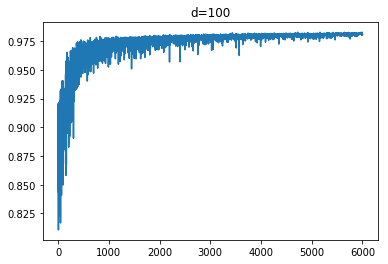

max:0.9826737967914438
time: 474.298621893


In [90]:
t0 = time.time()
result = CGA(266, eval_classification_loss, 0.01, iters=6000, log_every=100)
plt.figure()
plt.plot(result["max_history"]/9350.0)
plt.title('d=100')
plt.show()
print('max:' + str(max(result["max_history"])/9350.0))
print('time: ' + str(time.time() - t0))

Iteration: 0. Current max: 7832.0
Iteration: 20. Current max: 8776.0
Iteration: 40. Current max: 8895.0
Iteration: 60. Current max: 8895.0
Iteration: 80. Current max: 9018.0
Iteration: 100. Current max: 9018.0
Iteration: 120. Current max: 9044.0
Iteration: 140. Current max: 9067.0
Iteration: 160. Current max: 9075.0
Iteration: 180. Current max: 9102.0
Iteration: 200. Current max: 9139.0
Iteration: 220. Current max: 9139.0
Iteration: 240. Current max: 9139.0
Iteration: 260. Current max: 9139.0
Iteration: 280. Current max: 9139.0
Iteration: 300. Current max: 9139.0
Iteration: 320. Current max: 9144.0
Iteration: 340. Current max: 9152.0
Iteration: 360. Current max: 9152.0
Iteration: 380. Current max: 9152.0
Iteration: 400. Current max: 9152.0
Iteration: 420. Current max: 9152.0
Iteration: 440. Current max: 9152.0
Iteration: 460. Current max: 9152.0
Iteration: 480. Current max: 9152.0
Iteration: 500. Current max: 9152.0
Iteration: 520. Current max: 9155.0
Iteration: 540. Current max: 9160.

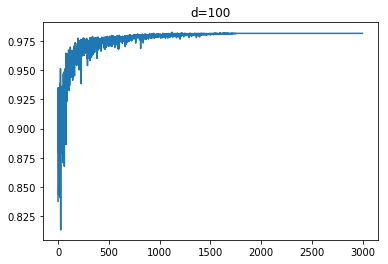

max:0.9824598930481283
time: 330.590624094


In [88]:
t0 = time.time()
result = CGA(266, eval_classification_loss, 0.03, iters=3000, log_every=20)
plt.figure()
plt.plot(result["max_history"]/9350.0)
plt.title('d=100')
plt.show()
print('max:' + str(max(result["max_history"])/9350.0))
print('time: ' + str(time.time() - t0))

/home/satyr/uczelnia/ewolucyjne/Katalog bez nazwy
Iteration: 0. Current max: 8328.0
Iteration: 20. Current max: 8411.0
Iteration: 40. Current max: 8609.0
Iteration: 60. Current max: 8609.0
Iteration: 80. Current max: 8609.0
Iteration: 100. Current max: 8609.0
Iteration: 120. Current max: 8781.0
Iteration: 140. Current max: 8781.0
Iteration: 160. Current max: 8781.0
Iteration: 180. Current max: 8781.0
Iteration: 200. Current max: 8781.0
Iteration: 220. Current max: 8826.0
Iteration: 240. Current max: 8826.0
Iteration: 260. Current max: 8826.0
Iteration: 280. Current max: 8826.0
Iteration: 300. Current max: 8826.0
Iteration: 320. Current max: 8826.0
Iteration: 340. Current max: 8826.0
Iteration: 360. Current max: 8826.0
Iteration: 380. Current max: 8826.0
Iteration: 400. Current max: 8826.0
Iteration: 420. Current max: 8826.0
Iteration: 440. Current max: 8826.0
Iteration: 460. Current max: 8826.0
Iteration: 480. Current max: 8826.0
Iteration: 500. Current max: 8826.0
Iteration: 520. Curr

Iteration: 4440. Current max: 9146.0
Iteration: 4460. Current max: 9146.0
Iteration: 4480. Current max: 9146.0
Iteration: 4500. Current max: 9146.0
Iteration: 4520. Current max: 9146.0
Iteration: 4540. Current max: 9146.0
Iteration: 4560. Current max: 9146.0
Iteration: 4580. Current max: 9146.0
Iteration: 4600. Current max: 9146.0
Iteration: 4620. Current max: 9146.0
Iteration: 4640. Current max: 9146.0
Iteration: 4660. Current max: 9146.0
Iteration: 4680. Current max: 9146.0
Iteration: 4700. Current max: 9146.0
Iteration: 4720. Current max: 9146.0
Iteration: 4740. Current max: 9146.0
Iteration: 4760. Current max: 9146.0
Iteration: 4780. Current max: 9146.0
Iteration: 4800. Current max: 9146.0
Iteration: 4820. Current max: 9150.0
Iteration: 4840. Current max: 9150.0
Iteration: 4860. Current max: 9150.0
Iteration: 4880. Current max: 9150.0
Iteration: 4900. Current max: 9150.0
Iteration: 4920. Current max: 9150.0
Iteration: 4940. Current max: 9150.0
Iteration: 4960. Current max: 9150.0
I

Iteration: 8880. Current max: 9164.0
Iteration: 8900. Current max: 9164.0
Iteration: 8920. Current max: 9164.0
Iteration: 8940. Current max: 9164.0
Iteration: 8960. Current max: 9164.0
Iteration: 8980. Current max: 9164.0
Iteration: 9000. Current max: 9164.0
Iteration: 9020. Current max: 9164.0
Iteration: 9040. Current max: 9164.0
Iteration: 9060. Current max: 9164.0
Iteration: 9080. Current max: 9164.0
Iteration: 9100. Current max: 9164.0
Iteration: 9120. Current max: 9164.0
Iteration: 9140. Current max: 9164.0
Iteration: 9160. Current max: 9164.0
Iteration: 9180. Current max: 9164.0
Iteration: 9200. Current max: 9164.0
Iteration: 9220. Current max: 9164.0
Iteration: 9240. Current max: 9164.0
Iteration: 9260. Current max: 9164.0
Iteration: 9280. Current max: 9164.0
Iteration: 9300. Current max: 9164.0
Iteration: 9320. Current max: 9164.0
Iteration: 9340. Current max: 9164.0
Iteration: 9360. Current max: 9164.0
Iteration: 9380. Current max: 9164.0
Iteration: 9400. Current max: 9164.0
I

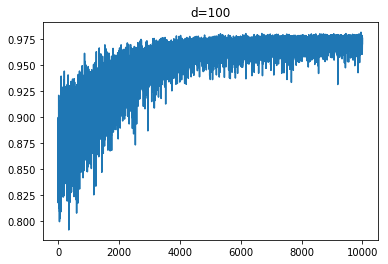

max:0.9812834224598931
time: 1038.32613993


In [85]:
t0 = time.time()
result = CGA(266, eval_classification_loss, 0.001, iters=10000, log_every=20)
plt.figure()
plt.plot(result["max_history"]/9350.0)
plt.title('d=100')
plt.show()
print('max:' + str(max(result["max_history"])/9350.0))
print('time: ' + str(time.time() - t0))

## UMDA

Iteration: 0. Current max: 8682.0
Iteration: 25. Current max: 9167.0
Iteration: 50. Current max: 9179.0
Iteration: 75. Current max: 9179.0
Iteration: 100. Current max: 9179.0
Iteration: 125. Current max: 9179.0
Iteration: 150. Current max: 9179.0
Iteration: 175. Current max: 9179.0
Iteration: 200. Current max: 9179.0
Iteration: 225. Current max: 9179.0
Iteration: 250. Current max: 9179.0


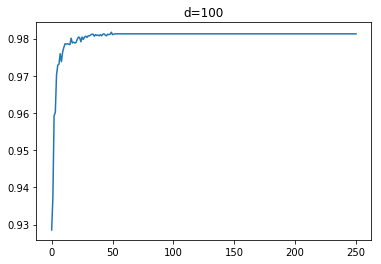

max:0.981711229946524
time: 632.652825117


In [92]:
# UMDA(N, M, d, F, iters=1000, log_every=0)
t0 = time.time()
result = UMDA(50, 25, 266, eval_classification_loss, iters=251, log_every=25)
plt.figure()
plt.plot(result["max_history"]/9350.0)
plt.title('d=100')
plt.show()
print('max:' + str(max(result["max_history"])/9350.0))
print('time: ' + str(time.time() - t0))

Iteration: 0. Current max: 8844.0
Iteration: 25. Current max: 9173.0
Iteration: 50. Current max: 9182.0
Iteration: 75. Current max: 9186.0
Iteration: 100. Current max: 9186.0
Iteration: 125. Current max: 9186.0
Iteration: 150. Current max: 9186.0
Iteration: 175. Current max: 9186.0
Iteration: 200. Current max: 9186.0
Iteration: 225. Current max: 9186.0
Iteration: 250. Current max: 9186.0


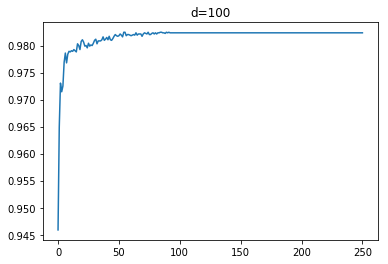

max:0.9824598930481283
time: 1113.58105898


In [94]:
# UMDA(N, M, d, F, iters=1000, log_every=0)
t0 = time.time()
result = UMDA(100, 50, 266, eval_classification_loss, iters=251, log_every=25)
plt.figure()
plt.plot(result["max_history"]/9350.0)
plt.title('d=100')
plt.show()
print('max:' + str(max(result["max_history"])/9350.0))
print('time: ' + str(time.time() - t0))

Iteration: 0. Current max: 8752.0
Iteration: 25. Current max: 9153.0
Iteration: 50. Current max: 9163.0
Iteration: 75. Current max: 9165.0
Iteration: 100. Current max: 9165.0
Iteration: 125. Current max: 9165.0
Iteration: 150. Current max: 9165.0
Iteration: 175. Current max: 9165.0
Iteration: 200. Current max: 9165.0
Iteration: 225. Current max: 9165.0
Iteration: 250. Current max: 9165.0


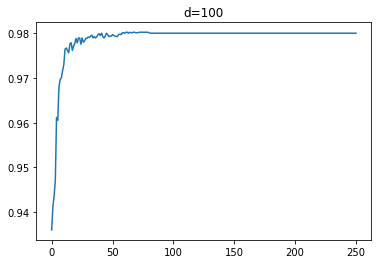

max:0.9802139037433155
time: 591.95718503


In [93]:
# UMDA(N, M, d, F, iters=1000, log_every=0)
t0 = time.time()
result = UMDA(50, 15, 266, eval_classification_loss, iters=251, log_every=25)
plt.figure()
plt.plot(result["max_history"]/9350.0)
plt.title('d=100')
plt.show()
print('max:' + str(max(result["max_history"])/9350.0))
print('time: ' + str(time.time() - t0))

# Zad 2
## MIMIC

Iteration: 0. Current max: 8719.0
Iteration: 10. Current max: 9134.0


/home/satyr/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:149: RuntimeWarning: Mean of empty slice.
/home/satyr/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:148: RuntimeWarning: Mean of empty slice.


Iteration: 20. Current max: 9157.0
Iteration: 30. Current max: 9173.0
Iteration: 40. Current max: 9173.0
Iteration: 50. Current max: 9178.0
Iteration: 60. Current max: 9186.0
Iteration: 70. Current max: 9187.0
Iteration: 80. Current max: 9190.0
Iteration: 90. Current max: 9191.0
Iteration: 100. Current max: 9196.0
Iteration: 110. Current max: 9199.0
Iteration: 120. Current max: 9199.0
Iteration: 130. Current max: 9199.0
Iteration: 140. Current max: 9199.0


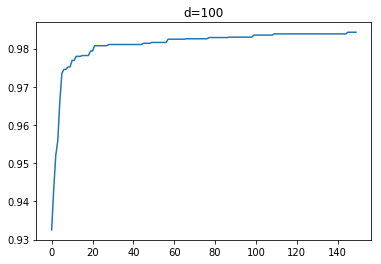

max:0.9842780748663101
time: 706.612129927


In [239]:
# UMDA(N, M, d, F, iters=1000, log_every=0)
t0 = time.time()
result = MIMIC(200, 100, 266, eval_classification_loss, iters=150, log_every=10)
plt.figure()
plt.plot(result["max_history"]/9350.0)
plt.title('d=100')
plt.show()
print('max:' + str(max(result["max_history"])/9350.0))
print('time: ' + str(time.time() - t0))